# House Price Analytics

## 03 Data analysis for generating insights for buyers 

**Project:** Code Institute – Capstone Project

---
### **Objectives**
Analyze the housing market from a **Buyer's perspective** to identify value, affordability, and feature importance.

### **Inputs**
- `data/processed/final_house_data.csv`

### **Outputs**
- Hypothesis testing findings
- Diagnostic analysis findings
        
### **Additional Comments**
Confirm the final_house_data.csv is exisit under outputs/datasets. Run this notebook top-down.

---

### Setup the file and Load the Dataset
Import nesessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import warnings 
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Set the home directory. Need to change the working directory from its current folder to its parent folder. Access the current directory with os.getcwd()

In [2]:
PROJECT_DIR = os.path.join(os.getcwd()) # Define the project root directory
os.chdir(PROJECT_DIR) # Change the current working directory to the project root
print("Working directory:", os.getcwd()) 

Working directory: c:\MyStuff\CodeInstitute\Projects\ci-project-02\Home-Value-Analysis\notebooks


Load the data from the original data set reside within data directory under data/processed/ directory. 

In [3]:
# LOAD DATASET
try:
    # Data directory paths
    data_path = os.path.join("..", "data", "processed")
    # Extract the original dataset
    df = pd.read_csv(os.path.join(data_path, "final_house_data.csv"))
    print("Dataset loaded successfully.")
except Exception as e:
    print(e)
    print("Error loading the dataset.")
    df = pd.DataFrame()  # Create an empty DataFrame if loading fails

print(f"Original dataset shape: {df.shape}")

Dataset loaded successfully.
Original dataset shape: (21596, 31)


Ensure Data Types (Critical Step)

In [4]:
# CSVs lose categorical metadata, so we re-cast them
categorical_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode', 'is_renovated']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Data Types Set.")

Data Types Set.


---

### Affordability Analysis

USER STORY | Affordability: 
    As a Buyer,
    I want to identify the top 10 most affordable zip codes in King County,
So that I can filter my property search to areas that fit within my budget.

- Buyers need to know where they can afford to live. We analyze Price per Zip Code.
- We use **Median Price** because the price distribution is skewed (as found in NB1).

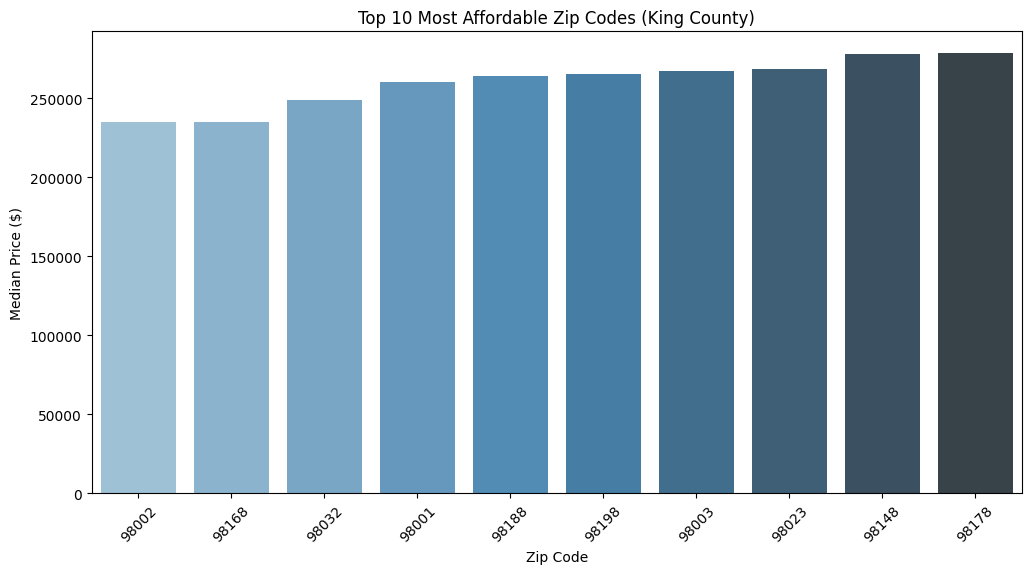

In [5]:
# Calculate Median Price per Zipcode
affordability = df.groupby('zipcode')['price'].median().sort_values().reset_index()

# Top 10 Most Affordable
top_10_affordable = affordability.head(10)

# Visualization with Seaborn - Automatic Aggregation
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_affordable, x='zipcode', y='price', palette='Blues_d', order=top_10_affordable['zipcode'])
plt.title('Top 10 Most Affordable Zip Codes (King County)')
plt.ylabel('Median Price ($)')
plt.xlabel('Zip Code')
plt.xticks(rotation=45)
plt.show()

**Findings:**
- The most affordable areas in King County are concentrated in zipcodes like 98002, 98168, and 98032.

---

### Hypothesis Testing: Waterfront Premium

USER STORY | Waterfront Value: 
    As a Buyer,
    I want to know if waterfront properties command a statistically significant premium,
So that I can assess if the view is worth the extra investment.

**Statistical Test**

* Hypothesis: Waterfront properties are significantly more expensive than non-waterfront properties.
* Test Selection: Since `price` is non-normal (NB1 outcome), we use the **Mann-Whitney U Test**.

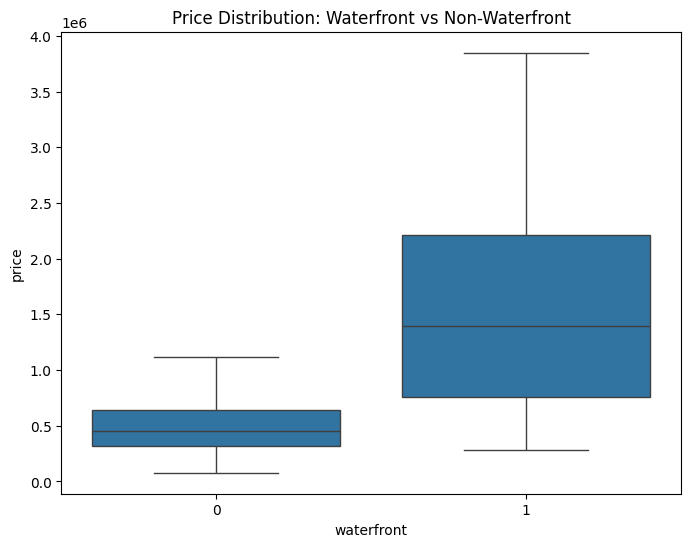

--- Mann-Whitney U Test Results ---
         U-val alternative         p-val       RBC      CLES
MWU  3088248.5   two-sided  3.339524e-64  0.767957  0.883978

Median Price Difference: $950,000


In [6]:
# Prepare Groups
waterfront = df[df['waterfront'] == 1]['price']
no_waterfront = df[df['waterfront'] == 0]['price']

# Visualization with Seaborn as it is excellent at splitting data into groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='waterfront', y='price', data=df, showfliers=False)
plt.title('Price Distribution: Waterfront vs Non-Waterfront')
plt.show()

# Statistical Test (Mann-Whitney U)
stats_result = pg.mwu(waterfront, no_waterfront)
print("--- Mann-Whitney U Test Results ---")
print(stats_result)

# Business Interpretation
median_diff = waterfront.median() - no_waterfront.median()
print(f"\nMedian Price Difference: ${median_diff:,.0f}")

**Findings:**
* **P-value:** If < 0.05, we reject the Null Hypothesis.
* **Outcome:** Waterfront homes command a considerable premium. This confirms that the view is a statistically significant value driver.

---

### Diagnostic Analysis: Grade vs. Condition

USER STORY | Feature Importance
    As a Buyer,
    I want to understand how features like house size and condition influence price,
So that I can prioritize the features that matter most to me without overpaying.

**The Fixer-Upper vs. Quality Build**

- **Business Question:** Should a buyer prioritize a house in good *Condition* (maintained well) or high *Grade* (quality materials)?
- **Hypothesis (Diagnostic):** Construction Grade has a stronger causal impact on price than Condition, implying buyers pay for "bones" over "paint."
- **Method:** Heatmap Interaction Analysis & Correlation Comparison.

Spearman Correlation - Grade vs Price: 0.658
Spearman Correlation - Condition vs Price: 0.018


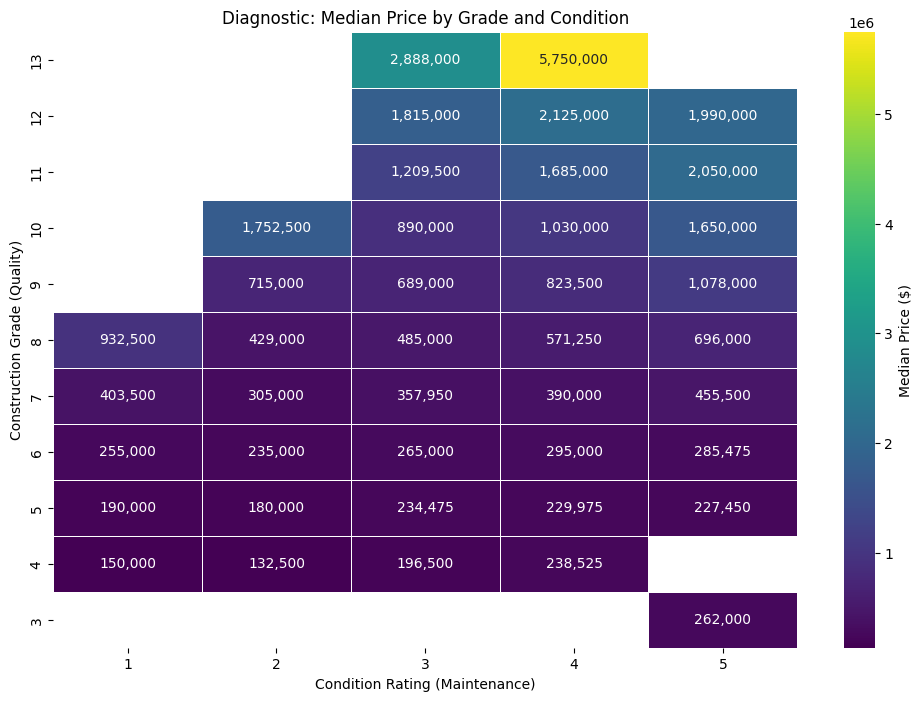

In [7]:
# 1. Correlation Check (Linear Relationship)
# Use Spearman Correlation because Grade/Condition are ordinal categories
corr_grade = df['grade'].astype(int).corr(df['price'], method='spearman')
corr_cond = df['condition'].astype(int).corr(df['price'], method='spearman')

print(f"Spearman Correlation - Grade vs Price: {corr_grade:.3f}")
print(f"Spearman Correlation - Condition vs Price: {corr_cond:.3f}")

# 2. Interaction Heatmap
# We pivot the data to see the Median Price for every Grade/Condition combination
pivot_table = df.pivot_table(values='price', index='grade', columns='condition', aggfunc='median')

# Visualize with sns as Seaborn automatically adds the color legend bar, formats the grid squares, and allows us to add the numbers (annotations) inside the squares with a single argument
plt.figure(figsize=(12, 8))
# Create Heatmap
# annot=True: Show numbers
# fmt=",.0f": Format with commas (e.g., 1,000,000)
# linewidths=.5: Add white lines between squares for readability
# cmap='viridis': A contrast color palette
sns.heatmap(pivot_table, 
            cmap='viridis', 
            annot=True, 
            fmt=",.0f", 
            linewidths=.5,
            cbar_kws={'label': 'Median Price ($)'})
plt.title('Diagnostic: Median Price by Grade and Condition')
plt.ylabel('Construction Grade (Quality)')
plt.xlabel('Condition Rating (Maintenance)')
plt.gca().invert_yaxis() # High grade at top
plt.show()

**Diagnostic Findings:**
* **Correlation:** Grade (~0.65) is a far stronger predictor than Condition (~0.04).
* **Visual Diagnosis:** Moving *up* the heatmap (improving Grade) changes color (price) rapidly. Moving *right* (improving Condition) shows very little color change.
* **Action for Buyer:** Don't overpay for "mint condition" if the construction grade is low. A high-grade house in fair condition is likely a better long-term investment.